In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt import loads

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

# satellite imagery modules

import sys
sys.path.append("/home/nbserver/satellite-image-tools/satimage-processing/")
import satimg 

In [2]:
# path to save data

outPath = "/home/data/world-cities/"

if not os.path.exists(outPath):
	os.makedirs(outPath)

# Set up sampling locations

In [3]:
# cities_df = pd.read_csv("/home/adalbert/data/global_areas.csv", names=["lat", "lon", "perimeter", "area", "region"])
cities_df_all = pd.read_csv(outPath + "worldcitiespop.txt")

cities_df_all = cities_df_all[(~cities_df_all.Population.isnull()) & 
                              (~cities_df_all.Latitude.isnull()) & 
                              (~cities_df_all.Longitude.isnull())]

cities_df_all.drop(["Region", "AccentCity"], 1, inplace=True)
cities_df_all.dropna(inplace=True)

# convert to geopandas dataframe with a spatial index
cities_df_all['geometry'] = map(lambda lat, lon: Point((lon, lat)), 
                                cities_df_all['Latitude'].values, 
                                cities_df_all['Longitude'].values)
cities_df_all = gpd.GeoDataFrame(cities_df_all)

def format_pop(pop):
    if pop > 1e6:
        div = 1e6
        s = 'M'
    else:
        div = 1e3
        s = 'k'
    return "%2.1f%s"%(float(pop)/div, s)

cities_df_all['City'] = map(lambda city, country, pop: "%s, %s (pop %s)"%(city, country, format_pop(pop)),
                        cities_df_all['City'], 
                        cities_df_all['Country'], 
                        cities_df_all['Population'])
cities_df_all['City'] = cities_df_all['City'].apply(lambda x: x.replace("-"," "))

cities_df_all.drop_duplicates("City", inplace=True)

cities_df = cities_df_all[cities_df_all.Population>10000]

cities_df.to_csv(outPath + "/urban_areas_over_10kpop.csv", index=False)
cities_df_all.to_csv(outPath + "/all_urban_areas.csv", index=False)

In [5]:
import geopy
from geopy import distance
from collections import OrderedDict
from sklearn.neighbors import KDTree, BallTree

point2loc = lambda p: tuple(np.array(p.centroid.coords.xy).squeeze())
    
cities_df.sort_values("Population", ascending=False, inplace=True)
cities_df = cities_df[cities_df['Population']>=1e5]
cities_df = cities_df.reset_index().drop("index", 1)
spatial_index = BallTree(cities_df[['Longitude', 'Latitude']], 
                         leaf_size=10)

# construct ordered dictionary of cities
cities_list = cities_df.to_dict("records")
cities_list.sort(key=lambda x: x['Population'])
cities_list = cities_list[::-1]
cities_dict = OrderedDict(zip([x['City'] for x in cities_list], cities_list))

In [ ]:
n_neighbors = 10   # number of nearest neighbors to query
d_threshold = 20  # radius in KM

to_remove = set()
already_visited = set()
new_pop = {}

i = 0
while i < len(cities_dict):
    c0 = cities_dict.keys()[i]
    if c0 in to_remove:
        i += 1
        continue
    already_visited = already_visited.union(set([c0]))
    print i, '/', len(cities_dict), ":", c0
    clear_output(wait=True)
    r0 = cities_dict[c0]
    p = r0['geometry']
    loc0 = point2loc(p)
    neighbors = spatial_index.query(loc0, k=n_neighbors)[1][0][1:]
    new_pop[c0] = r0['Population']
    for j,n in enumerate(neighbors):
        r = cities_df.iloc[n]
        c = r['City']
        loc = point2loc(r['geometry'])
        d = distance.distance(loc0, loc).km
        if d > 0 and d <= d_threshold and c not in already_visited:
            to_remove = to_remove.union(set([c]))
            new_pop[c0] += r['Population']
    i += 1
    
cities_df_sel = cities_df[~cities_df['City'].isin(to_remove)]
cities_df_sel['Adj. population'] = map(lambda c,p: new_pop[c] if c in new_pop else p,
                                  cities_df_sel['City'], cities_df_sel['Population'])
cities_df_sel.reset_index(inplace=True)

print "Removing %d cities. "%(len(to_remove))

In [4]:
# cities_df_sel.to_csv(outPath + "/selected_urban_areas.csv")

cities_df_sel = gpd.GeoDataFrame(pd.read_csv(outPath + "/selected_urban_areas.csv"))
cities_df_sel['geometry'] = cities_df_sel['geometry'].apply(lambda x: loads(x))

(array([-60., -40., -20.,   0.,  20.,  40.,  60.,  80.]),
 <a list of 8 Text yticklabel objects>)

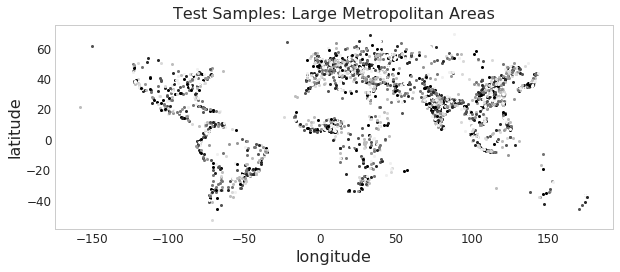

In [6]:
cities_df_sel.plot(figsize=(10,6), cmap='Greys')
plt.title("Test Samples: Large Metropolitan Areas", fontsize=16)
plt.ylabel("latitude", fontsize=16)
plt.xlabel("longitude", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [7]:
def f_classify_by_pop(d):
    if d < 50000:
        return "very-small"
    elif d < 100000:
        return "small"
    elif d < 1e6:
        return "medium"
    elif d < 2e6:
        return "large"
    elif d < 5e6:
        return "very-large"
    else:
        return "megalopolis"

cities_df['class'] = cities_df["Population"].apply(f_classify_by_pop)
cities_df_all['class'] = cities_df_all["Population"].apply(f_classify_by_pop)
cities_df_sel['class'] = cities_df_sel["Population"].apply(f_classify_by_pop)


In [8]:
dist_25 = cities_df['class'].value_counts() / float(len(cities_df))
dist_03 = cities_df_sel['class'].value_counts() / float(len(cities_df_sel))

# Extract city samples

In [9]:
# client for SAR built geometry
sarPath = "/home/data/guf28_merged.tif"
sarFiles = glob.glob(sarPath)
sarImgClient = satimg.SatImage(sarFiles)

(-65.00066738877278, -180.0003314054922, 85.00000094500146, 180.00111704000867)


In [10]:
# client for nightlights
nliPath = "/home/data/VIIRS/2015/"
nliFiles = glob.glob(nliPath + "/viirs_merged.tif")
nliImgClient = satimg.SatImage(nliFiles)

(-64.99791778665006, -180.00208333335016, 75.00208333335007, 179.9979195466502)


In [11]:
# client for nightlights
nliPath = "/home/data/"
nliFiles = glob.glob(nliPath + "/F16_20100111-20110731_rad_v4.avg_vis.tif")
nliImgClientOld = satimg.SatImage(nliFiles)

(-65.00416610665006, -180.00416666665018, 75.00416666665006, 180.00416522665017)


In [12]:
# client for population density
popPath = "/home/data/landscan-population/LandScan2012/ArcGIS/Population/lspop2012/"
popFiles = glob.glob(popPath + "w001001x.adf")
popImgClient = satimg.SatImage(popFiles)

(-90.00000000000009, -180.00000000000017, 83.9999999999305, 179.9999999998562)


In [13]:
def basic_preprocess(img, res, log=False):
    if img is None:
        return None
    img[img<0] = 0
    img = np.ceil(resize(img.squeeze(), (res,res), preserve_range=True))#.astype(int)
    if log:
        img = np.log(img + 1e-3)
    img = (img - img.min()) / (img.max() - img.min())
    return img

#### Plot some examples

In [14]:
nimg = 4
nrow = 3

# smpl_df = cities_df_sel[cities_df_sel['Population']>2e6].sample(nimg).reset_index()

mycities = ["paris, fr", "delhi, in", "san francisco, us", "boston, us"]

smpl_df = cities_df_sel[cities_df_sel['City']\
            .apply(lambda x: sum([s in x for s in mycities])>0)].reset_index()


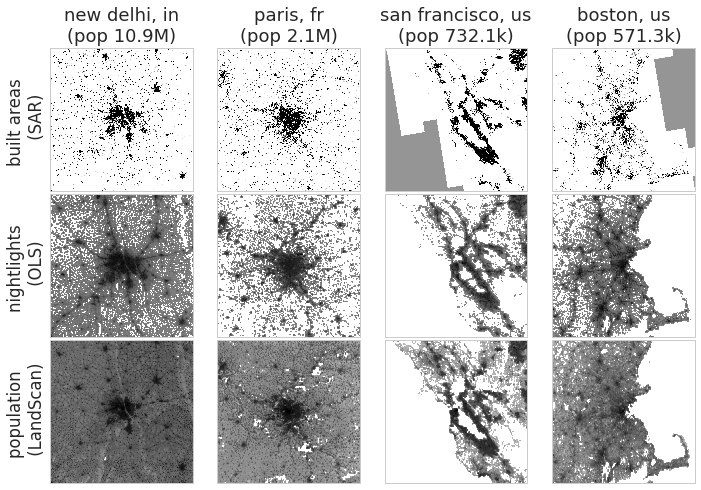

In [18]:
import matplotlib.gridspec as gridspec

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(12,8))
gs1 = gridspec.GridSpec(nrow, nimg)
gs1.update(wspace=0, hspace=0.025) # set the spacing between axes. 

for k,(i,r) in enumerate(smpl_df.iterrows()):
    lat, lon, city, pop, country = r['Latitude'], r['Longitude'], r['City'], r['Population'], r['Country']
    # print city, lat, lon, pop, country
    imgSAR = sarImgClient.get_image_at_location((lat, lon), w=200)
    imgSAR = basic_preprocess(imgSAR, 286)
    imgNLI = nliImgClient.get_image_at_location((lat, lon), w=200)
    imgNLI = basic_preprocess(imgNLI, 286, log=True)
    imgNLO = nliImgClient.get_image_at_location((lat, lon), w=200)
    imgNLO = basic_preprocess(imgNLO, 286, log=True)
    imgPOP = popImgClient.get_image_at_location((lat, lon), w=200)
    imgPOP = basic_preprocess(imgPOP, 286, log=True)
    ax0 = plt.subplot(gs1[0,i]); ax0.set_xticks([]); ax0.set_yticks([])
    ax1 = plt.subplot(gs1[1,i]); ax1.set_xticks([]); ax1.set_yticks([])
    ax2 = plt.subplot(gs1[2,i]); ax2.set_xticks([]); ax2.set_yticks([])
    ax0.imshow(imgSAR,cmap='Greys'); ax0.set_ylabel("built areas \n (SAR)") if i==0 else None
    ax1.imshow(imgNLO,cmap='Greys'); ax1.set_ylabel("nightlights \n (OLS)") if i==0 else None
    ax2.imshow(imgPOP,cmap='Greys'); ax2.set_ylabel("population \n (LandScan)") if i==0 else None
    ax0.set_title(city.replace(" (", "\n("))
    

#### Extract  samples: 
* training: all cities > 10k population
* test: filtered cities (by population & location)

In [ ]:
kmScale = 200 # window of 200km width around center
res = 286

# training samples
df = cities_df_all[cities_df_all.Population>10000]
phase = "urban_areas_over_10kpop_log"

cur_dir = outPath + "/%s"%(phase)
if not os.path.exists(cur_dir):
    os.makedirs(cur_dir)

from skimage.io import imsave

fig, ax = plt.subplots(1,3, figsize=(12,4))

for i,(idx,r) in enumerate(df.iterrows()):
    imgLat, imgLon = r['Latitude'], r['Longitude']
    city, country = r['City'].replace(" ", "-"), r['Country']
    popNum, popClass = int(r['Population']), r['class'].replace(" ","-")
    
    clear_output(wait=True)
    print "city %d/%d" % (i, len(df))

    imgSAR = sarImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
    imgSAR = basic_preprocess(imgSAR, res)
    imgNLI = nliImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
    imgNLI = basic_preprocess(imgNLI, res, log=True)
    imgNLO = nliImgClientOld.get_image_at_location((imgLat, imgLon), w=kmScale)
    imgNLO = basic_preprocess(imgNLO, res, log=True)
    imgPOP = popImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
    imgPOP = basic_preprocess(imgPOP, res, log=True)
    if imgSAR is None or imgNLI is None or imgPOP is None:
        continue
    if imgNLO is None:
        continue
        
    # construct water mask (areas restricted to building)
    imgWTR = (np.abs(imgSAR-128)>1).astype(np.uint8)

    # put everything together in a 3-channel image: POP+LUM+Mask
    imgPNM = np.zeros((res,res,3), dtype=float)
    imgPNM[:,:,0] = imgPOP
    imgPNM[:,:,1] = imgNLI
    imgPNM[:,:,2] = imgWTR
        
    # put everything together in a 3-channel image: POP+SAR+Mask
    imgPSM = np.zeros((res,res,3), dtype=float)
    imgPSM[:,:,0] = imgPOP
    imgPSM[:,:,1] = imgSAR
    imgPSM[:,:,2] = imgWTR
               
    # put everything together in a 3-channel image: POP+SAR+NLO
    imgPSN = np.zeros((res,res,3), dtype=float)
    imgPSN[:,:,0] = imgPOP
    imgPSN[:,:,1] = imgSAR
    imgPSN[:,:,2] = imgNLO
               
    # save images to files
    filename = "%s/SAR_%s_%s_%s_%d_%2.4f_%2.4f.png"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgSAR)
    filename = "%s/NLO_%s_%s_%s_%d_%2.4f_%2.4f.png"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgNLO)
    filename = "%s/NLI_%s_%s_%s_%d_%2.4f_%2.4f.png"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgNLI)
    filename = "%s/POP_%s_%s_%s_%d_%2.4f_%2.4f.png"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgPOP)
    filename = "%s/PNM_%s_%s_%s_%d_%2.4f_%2.4f.png"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgPNM)
    filename = "%s/PSM_%s_%s_%s_%d_%2.4f_%2.4f.png"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgPSM)
    filename = "%s/PSN_%s_%s_%s_%d_%2.4f_%2.4f.png"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgPSN)

    # display samples every now and then
    if i % 100 == 0 and imgSAR is not None:
        sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
        ax[0].imshow(imgSAR); ax[0].set_title("built areas \n (SAR)")
        ax[1].imshow(imgNLO); ax[1].set_title("nightlights \n (VIIRS)")
        ax[2].imshow(imgPOP); ax[2].set_title("population \n (LandScan)")
        fig.suptitle(city.replace(" (", "\n("), fontsize=20)
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

city 271/25024
